<a href="https://colab.research.google.com/github/navinabalab2007-ux/sentiment/blob/main/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv", engine='python', on_bad_lines='skip')

In [ ]:
movie_reviews.shape

(41223, 2)

In [ ]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
movie_reviews.isnull().values.any()

np.False_

<Axes: xlabel='sentiment', ylabel='count'>

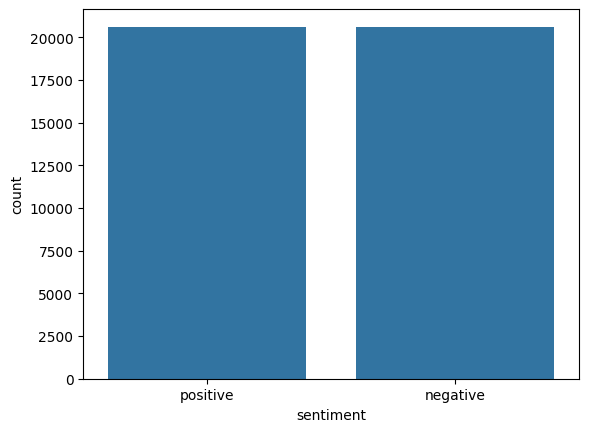

In [ ]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

In [ ]:
movie_reviews["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()


    sentence = remove_tags(sentence)

    sentence = re.sub('[^a-zA-Z]', ' ', sentence)


    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    sentence = re.sub(r'\s+', ' ', sentence)

    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [ ]:


X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [ ]:


y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)



In [ ]:


word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:


vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

85076

In [ ]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:


embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(85076, 100)

In [ ]:


snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     8,507,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,507,600 (32.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,507,600 (32.45 MB)

None


In [ ]:


snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.6589 - loss: 0.6176 - val_acc: 0.7573 - val_loss: 0.5112
Epoch 2/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.7944 - loss: 0.4526 - val_acc: 0.7690 - val_loss: 0.4964
Epoch 3/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8228 - loss: 0.4076 - val_acc: 0.7620 - val_loss: 0.5064
Epoch 4/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8401 - loss: 0.3718 - val_acc: 0.7594 - val_loss: 0.5100
Epoch 5/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8474 - loss: 0.3614 - val_acc: 0.7617 - val_loss: 0.5165
Epoch 6/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8549 - loss: 0.3448 - val_acc: 0.7524 - val_loss: 0.5490


In [ ]:
score = snn_model.evaluate(X_test, y_test, verbose=1)

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7467 - loss: 0.5680


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5778290629386902
Test Accuracy: 0.7416616082191467


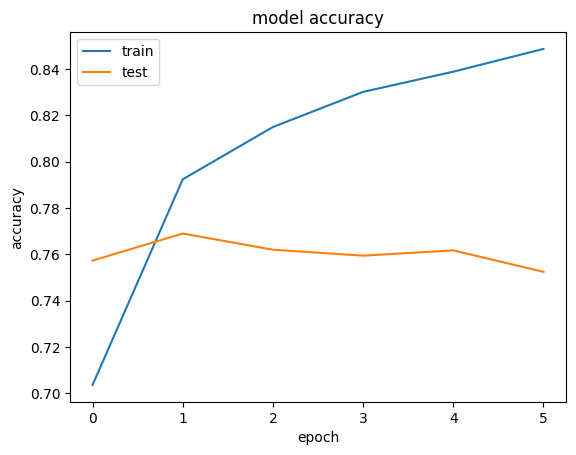

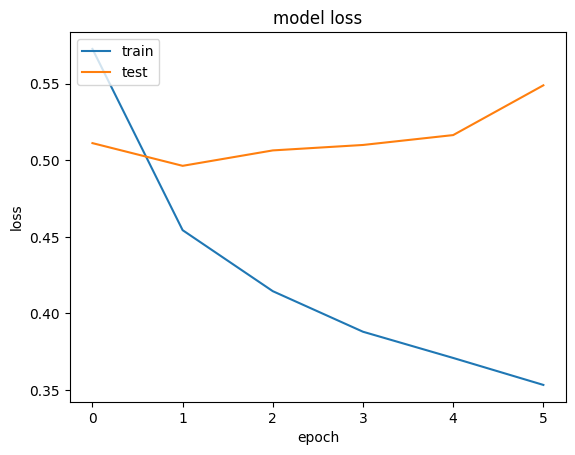

In [ ]:


import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
from keras.layers import Conv1D

In [ ]:


cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     8,507,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,507,600 (32.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,507,600 (32.45 MB)

None


In [ ]:


cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 24s 110ms/step - acc: 0.6991 - loss: 0.5618 - val_acc: 0.8270 - val_loss: 0.3911
Epoch 2/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - acc: 0.8503 - loss: 0.3567 - val_acc: 0.8420 - val_loss: 0.3596
Epoch 3/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - acc: 0.8860 - loss: 0.2872 - val_acc: 0.8288 - val_loss: 0.3783
Epoch 4/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 40s 105ms/step - acc: 0.9074 - loss: 0.2504 - val_acc: 0.8399 - val_loss: 0.3571
Epoch 5/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 22s 106ms/step - acc: 0.9257 - loss: 0.2105 - val_acc: 0.8481 - val_loss: 0.3505
Epoch 6/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - acc: 0.9428 - loss: 0.1797 - val_acc: 0.8478 - val_loss: 0.3585


In [ ]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - acc: 0.8483 - loss: 0.3525


In [ ]:


print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3630211055278778
Test Accuracy: 0.8440266847610474


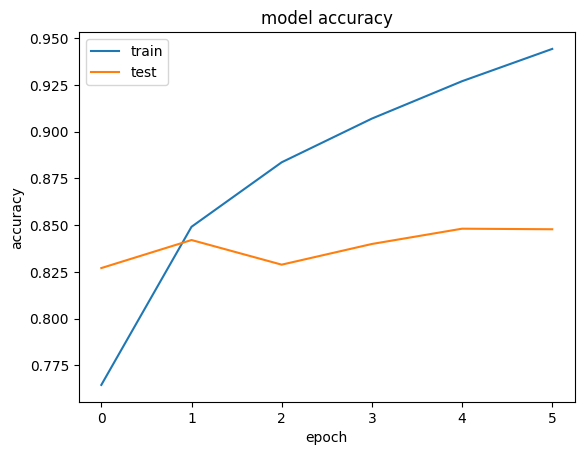

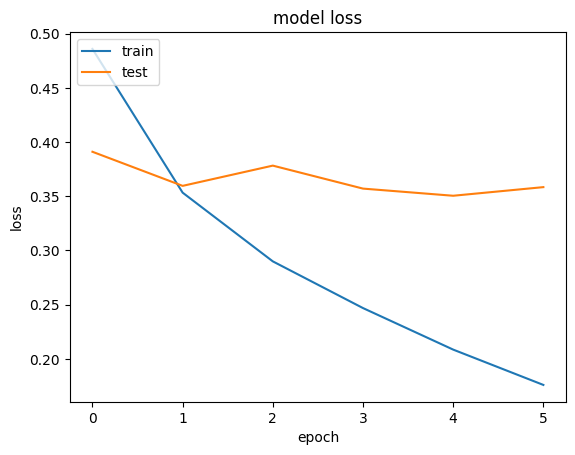

In [ ]:


import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [ ]:
from keras.layers import LSTM

In [ ]:


lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     8,507,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,507,600 (32.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,507,600 (32.45 MB)

None


In [ ]:


lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 85s 389ms/step - acc: 0.6629 - loss: 0.6058 - val_acc: 0.8064 - val_loss: 0.4415
Epoch 2/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 85s 414ms/step - acc: 0.8040 - loss: 0.4413 - val_acc: 0.8300 - val_loss: 0.3872
Epoch 3/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 96s 464ms/step - acc: 0.8197 - loss: 0.3988 - val_acc: 0.7502 - val_loss: 0.4945
Epoch 4/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 74s 356ms/step - acc: 0.8093 - loss: 0.4210 - val_acc: 0.8526 - val_loss: 0.3403
Epoch 5/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 79s 344ms/step - acc: 0.8619 - loss: 0.3291 - val_acc: 0.8581 - val_loss: 0.3272
Epoch 6/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 71s 342ms/step - acc: 0.8683 - loss: 0.3125 - val_acc: 0.8695 - val_loss: 0.3144


In [ ]:


score = lstm_model.evaluate(X_test, y_test, verbose=1)

258/258 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - acc: 0.8684 - loss: 0.3053


In [ ]:


print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.31915873289108276
Test Accuracy: 0.8628259301185608


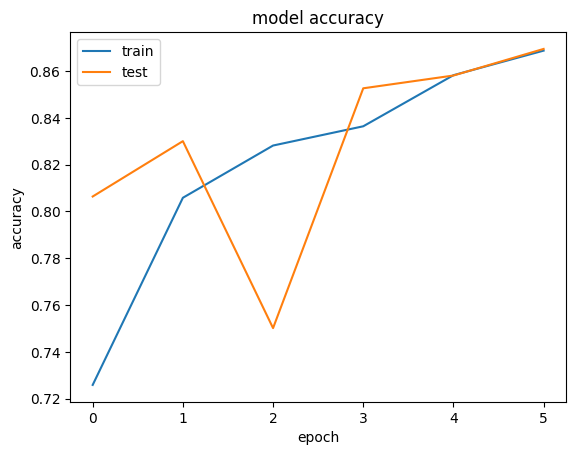

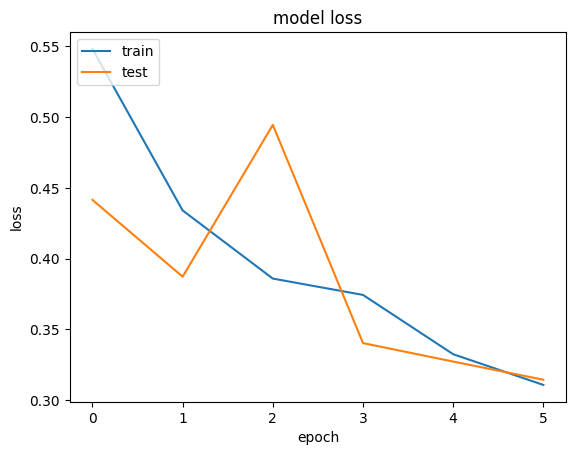

In [ ]:


import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:


lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

In [ ]:
!ls

a1_IMDB_Dataset.csv			      c1_lstm_model_acc_0.863.h5
a2_glove.6B.100d.txt			      c1_lstm_model_acc_0.864.h5
a3_IMDb_Unseen_Reviews.csv		      sample_data
b_SentimentAnalysis_with_NeuralNetwork.ipynb


In [ ]:


sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [ ]:


unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [ ]:

unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [ ]:

unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


array([[0.79586136],
       [0.97895646],
       [0.12726864],
       [0.66455364],
       [0.9546267 ],
       [0.01673508]], dtype=float32)

In [ ]:


sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.0
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.8
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,1.3
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,6.6
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.5
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.2
